In [49]:
import numpy
import pandas
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

In [74]:
def make_lags(frame, nl):
    cols = frame.columns.values
    for j in range(nl):
        cols_lagged = ['{0}_LAG{1}'.format(c, j+1) for c in cols]
        frame[cols_lagged] = frame[cols].shift(j+1)
    return frame


def apply_rf(f, m, h, l):

    data_lag = pandas.read_csv('./data/{0}_lag.csv'.format(f))
    data_app = pandas.read_csv('./data/{0}_app.csv'.format(f))

    data_joint = pandas.concat((data_lag, data_app), axis=0, ignore_index=True)
    data_joint = make_lags(frame=data_joint, nl=l)

    # .iloc[data_lag.shape[0]:, :]

    x_factors = [c for c in data_joint.columns if ((f in c) and ('LAG' in c))]

    sub_train = data_joint.iloc[l:data_lag.shape[0], :].copy()
    x_sub_train = sub_train[x_factors].values
    y_sub_train = sub_train[f].values

    model = RandomForestRegressor()
    model.fit(X=x_sub_train, y=y_sub_train)

    preds = data_joint.iloc[data_lag.shape[0]:, :].copy()
    preds['{0}_rf_hat'.format(f)] = model.predict(X=preds[x_factors].values)

    stds = numpy.concatenate([model.predict(preds[x_factors].values).reshape(-1, 1) for tree in model.estimators_], axis=1).std(axis=1, ddof=1) / numpy.power(len(model.estimators_), 0.5)
    preds['{0}_rf_hat_upper'.format(f)] = preds['{0}_rf_hat'.format(f)] + stats.t.ppf(q=0.975, df=(len(model.estimators_)-1)) * stds
    preds['{0}_rf_hat_lower'.format(f)] = preds['{0}_rf_hat'.format(f)] + stats.t.ppf(q=0.025, df=(len(model.estimators_)-1)) * stds
    jets = preds[['DATE', '{0}_rf_hat'.format(f), '{0}_rf_hat_upper'.format(f), '{0}_rf_hat_lower'.format(f), f]].copy()
    jets.to_csv('./data/{0}_rf_pred.csv'.format(f), index=False)
    res = "OK"
    return res


In [75]:
driver = 'JTU5300QUL'
d = './data/{0}.csv'

data = pandas.read_csv(d.format(driver))
data

,DATE,JTU5300QUL
0,2000-12-01,50
1,2001-01-01,80
2,2001-02-01,29
3,2001-03-01,28
4,2001-04-01,52
...,...,...
266,2023-02-01,42
267,2023-03-01,44
268,2023-04-01,56
269,2023-05-01,39


In [76]:
d_lag = './data/{0}_lag.csv'
d_app = './data/{0}_app.csv'

lag_umpk = 40
data.iloc[:lag_umpk, :].to_csv(d_lag.format(driver), index=False)
data.iloc[lag_umpk:, :].to_csv(d_app.format(driver), index=False)

In [77]:
apply_rf(f=driver, m=12, h=1, l=10)

'OK'

In [78]:
data_est = pandas.read_csv('./data/{0}_rf_pred.csv'.format(driver)).rename(columns={driver: '{0}_orig'.format(driver)})
data_est

,DATE,JTU5300QUL_rf_hat,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat_lower,JTU5300QUL_orig
0,2004-04-01,46.58,46.58,46.58,58
1,2004-05-01,46.00,46.00,46.00,61
2,2004-06-01,43.61,43.61,43.61,70
3,2004-07-01,51.89,51.89,51.89,90
4,2004-08-01,45.89,45.89,45.89,43
...,...,...,...,...,...
226,2023-02-01,39.22,39.22,39.22,42
227,2023-03-01,29.87,29.87,29.87,44
228,2023-04-01,36.90,36.90,36.90,56
229,2023-05-01,35.69,35.69,35.69,39


In [79]:
data = data.merge(right=data_est, left_on='DATE', right_on='DATE', how='left')
data

,DATE,JTU5300QUL,JTU5300QUL_rf_hat,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat_lower,JTU5300QUL_orig
0,2000-12-01,50,NaN,NaN,NaN,NaN
1,2001-01-01,80,NaN,NaN,NaN,NaN
2,2001-02-01,29,NaN,NaN,NaN,NaN
3,2001-03-01,28,NaN,NaN,NaN,NaN
4,2001-04-01,52,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
266,2023-02-01,42,39.22,39.22,39.22,42.0
267,2023-03-01,44,29.87,29.87,29.87,44.0
268,2023-04-01,56,36.90,36.90,36.90,56.0
269,2023-05-01,39,35.69,35.69,35.69,39.0


In [84]:
data_final = data.dropna()
data_final

,DATE,JTU5300QUL,JTU5300QUL_rf_hat,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat_lower,JTU5300QUL_orig
40,2004-04-01,58,46.58,46.58,46.58,58.0
41,2004-05-01,61,46.00,46.00,46.00,61.0
42,2004-06-01,70,43.61,43.61,43.61,70.0
43,2004-07-01,90,51.89,51.89,51.89,90.0
44,2004-08-01,43,45.89,45.89,45.89,43.0
...,...,...,...,...,...,...
266,2023-02-01,42,39.22,39.22,39.22,42.0
267,2023-03-01,44,29.87,29.87,29.87,44.0
268,2023-04-01,56,36.90,36.90,36.90,56.0
269,2023-05-01,39,35.69,35.69,35.69,39.0


In [85]:
data_final[data_final[driver] != data_final['{0}_orig'.format(driver)]]

,DATE,JTU5300QUL,JTU5300QUL_rf_hat,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat_lower,JTU5300QUL_orig


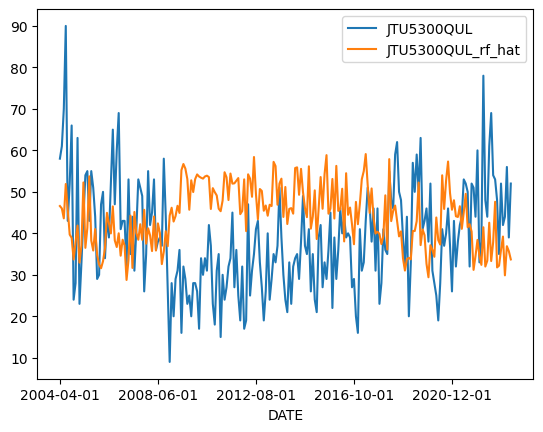

In [86]:
ax = data_final.set_index('DATE')[[driver, '{0}_rf_hat'.format(driver)]].plot()
ax.fill_between(data_final['DATE'].values, data_final['{0}_rf_hat_lower'.format(driver)].values, data_final['{0}_rf_hat_upper'.format(driver)].values, alpha=0.2)